### Imports and Configuration

In [52]:
import gymnasium as gym

import time
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm.notebook import tqdm
import pandas as pd
import pickle

In [53]:
configuration = {

    # Parametrization bellow cannot be changed
    "lanes_count" : 10, # The environment must always have 10 lanes
    "vehicles_count": 50, # The environment must always have 50 other vehicles
    "duration": 120,  # [s] The environment must terminate never before 120 seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle", # This is the policy of the other vehicles
    "initial_spacing": 2, # Initial spacing between vehicles needs to be at most 2

    # Refer to refer to https://highway-env.farama.org/observations/ to change observation space type
    "observation": {
        "type": "Kinematics"
    },

    # Refer to refer to https://highway-env.farama.org/actions/ to change action space type
    "action": {
        "type": "DiscreteMetaAction",
    },

    # Parameterization bellow can be changed (as it refers mostly to the reward system)
    # "collision_reward": -10,  # The reward received when colliding with a vehicle. (Can be changed)
    # "reward_speed_range": [20, 30],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD]. (Can be changed)
    "simulation_frequency": 15, #15,  # [Hz] (Can be changed)
    "policy_frequency": 5, #5,  # [Hz] (Can be changed)

    "collision_reward": -100,  # The reward received when colliding with a vehicle.
    "right_lane_reward": 0.1,  # The reward received when driving on the right-most lanes, linearly mapped to
    # zero for other lanes.
    "high_speed_reward": 100,  # The reward received when driving at full speed, linearly mapped to zero for
    # lower speeds according to config["reward_speed_range"].
    "lane_change_reward": 0,  # The reward received at each lane change action.
    "reward_speed_range": [20, 30],
    
    # Parameters defined bellow are purely for visualiztion purposes! You can alter them as you please
    "screen_width": 800,  # [px]
    "screen_height": 600,  # [px]
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False
}

default_config = configuration.copy()

### Checking the environment 

In [3]:
occupancyGrid = configuration.copy()
occupancyGrid["observation"] =  {
    "type": "OccupancyGrid",
    # "vehicles_count": 50,
    "features": [
                "presence",
                #"x", "y", 
                #"vx", "vy"
                ],
    # "features_range": {
    #      "x": [-500, 500],
    #      "y": [-500, 500],
    #     "vx": [-20, 20],
    #     "vy": [-20, 20]
    # },
    "grid_size": [[-100, 100], [-100, 100]],    # X controls how many lanes, Y controls how far ahead
    "grid_step": [1, 1],
    #"absolute": False,                     # Not implemented in the library
    #"as_image": True,
    # "align_to_vehicle_axes" : True
}

# The higher the number, the more frequent the policy and the simulation frequencies, the slower the simulation
occupancyGrid["simulation_frequency"] = 15
occupancyGrid["policy_frequency"] = 1

env = gym.make('highway-v0', render_mode='human', config=occupancyGrid)

obs, info = env.reset(seed = 30)

env.close()

obs

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [4]:
# Generate an episode of the environment and show the rewards and cumulative rewards
cum_reward = 0
with gym.make("highway-v0", config=occupancyGrid, render_mode='human') as env:
    obs = env.reset()
    for _ in range(1000):
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        cum_reward += reward
        print(reward, cum_reward)
        if done:
            break

0.750013881947915 0.750013881947915
0.0003886945416181051 0.750402576489533


In [ ]:
class OccupancyGrid():
    def __init__(
            self,
            grid_size=[[-50, 50], [-50, 50]],  # X controls the lane-width, Y controls how far ahead
            grid_step=[1, 1],
            colision_reward=-100,
            skew_speed=1,
            policy=None,
            sim_frequency=10,
            policy_frequency=1,
            render_mode = 'human',
            seed = 50,
    ):
        """
        Occupancy view class constructor
        Arguments:
            grid_size: list of lists, the size of the grid in the x and y direction, where x controls the lane-width and y controls how far ahead. Lanes are 5m wide, and the car position is (0,0)
            grid_step: list, the step size of the grid in the x and y direction, in meters
            colision_reward: float, the reward to give when a colision occurs
            skew_speed: float, the skew speed to apply to the reward
            policy: function, the policy to use in the simulation
            sim_frequency: int, the frequency of the simulation
            policy_frequency: int, the frequency of the policy
            render_mode: str, the mode to render the simulation
            seed: int, the seed to use in the simulation
        """

        self.grid_size = grid_size
        self.grid_step = grid_step
        self.config = default_config.copy()
        self.config["observation"] =  {
            "type": "OccupancyGrid",
            "features": ["presence"],
            "grid_size": grid_size,    # X controls how many lanes, Y controls how far ahead
            "grid_step": grid_step,
        }
        self.config["simulation_frequency"] = sim_frequency
        self.config["policy_frequency"] = policy_frequency
        self.render_mode = render_mode
        self.seed = seed
        self.policy = policy
        self.colision_reward = colision_reward
        self.skew_speed = skew_speed
        self.initialize_states()


    def initialize_states(self):
        """
        Initialize the states of the occupancy grid
        """
        # Start the environment
        with gym.make('highway-v0', render_mode=self.render_mode, config=self.config) as env:
            obs, info = env.reset(seed = self.seed)
            self.current_obs = obs
            self.env = env
        
    def get_state(self):
        """
        Get the state of the environment
        """
        pass

    def test_env(self):
        """
        Function to test the environment with a random policy, or with a policy
        """
        obs, info = self.env.reset(seed = self.seed)
        self.current_obs = obs
        done = False
        while not done:
            # start = time.time()
            if self.policy is None:
                action = self.env.action_space.sample()
            else:
                action = self.policy()
            obs, reward, done, truncate, info = self.env.step(action)
            self.current_obs = obs
            print(self.get_state(type='lane-wise', decode=True), decode_meta_action(action), fix_reward(reward, skew_speed=2))
            time.sleep(1)
            # end = time.time()
            # print(f"Time taken: {end-start}")
        self.env.close()
        return info["score"]

# ------------------- SARSA -------------------    
class Sarsa(OccupancyGrid):
    def __init__(
        self,
        alpha=0.75,
        gamma=0.95,
        epsilon=0.6,
        print_stats=False,
        **kwargs,
        ):
        """
        SARSA class constructor
        Arguments:
            alpha: float, the learning rate
            gamma: float, the discount factor
            m: int, the number of episodes to train the agent for
            epsilon: float, the epsilon value for the epsilon-greedy policy
            print_stats: bool, whether to print the statistics during initialization
        """

        super().__init__(**kwargs)
        self.initialize_Q(print_stats)
        self.alpha, self.gamma, self.epsilon = alpha, gamma, epsilon

    def policy_Q(self, state):
        values = [self.Q[(state, action)] for action in range(5)]
        return np.argmax(values)   

    def initialize_Q(self, print_stats = False):
        # Combine the possible states with the possible actions
        keys = list(itertools.product(self.states, range(5)))       # 5 possible actions, 0-4: left, idle, right, accelerate, decelerate
        if len(keys) > 150000:
            print("Warning: The number of states is too large, consider reducing the number of states")
        if print_stats:
            print(f"Number of states: {len(keys)}")   
        self.Q = {key: 0 for key in keys}

    def epsilon_greedy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(5)
        else:
            values = [self.Q[(state, action)] for action in range(5)]
            return np.argmax(values)
        
    def train(self, m=100, verbose=0): 
        env = gym.make('highway-v0', render_mode=None, config=self.config)
        obs, info = env.reset(seed = np.random.randint(1000))
        self.current_obs = obs
        done = False
        state = self.get_state()
        action = self.epsilon_greedy(state)
        q_explored = np.count_nonzero(list(self.Q.values()))
        for i in tqdm(range(m)):
            env.reset()
            cum_reward = 0
            done = False
            while not done:
                next_obs, reward, done, truncate, info = env.step(action)
                reward = fix_reward(reward, done=done, colision_reward=self.colision_reward, skew_speed=self.skew_speed)
                next_state = self.get_state()
                next_action = self.epsilon_greedy(next_state)

                print(next_state, decode_meta_action(next_action), reward) if verbose > 2 else None
                if self.Q[(state, action)] == 0:
                    q_explored += 1
                cum_reward += reward

                self.Q[(state, action)] += self.alpha*(reward + self.gamma*self.Q[(next_state, next_action)] - self.Q[(state, action)])
                state, action = next_state, next_action
                self.current_obs = next_obs
            print(f"Episode {i+1} completed, cumulative reward: {cum_reward}") if verbose > 0 else None
            print(f"Q explored: {100*q_explored/len(self.Q)}") if verbose > 1 else None
        env.close()

    def test(self):
        env = gym.make('highway-v0', render_mode=self.render_mode, config=self.config)
        obs, info = env.reset(seed = self.seed)
        self.current_obs = obs
        done = False
        state = self.get_state(self.state_type)
        action = self.policy_Q(state)
        while not done:
            next_obs, reward, done, truncate, info = env.step(action)
            next_state = self.get_state(self.state_type)
            next_action = self.policy_Q(next_state)
            state, action = next_state, next_action
            self.current_obs = next_obs
            print(next_state)
        env.close()
        return info["score"]

- grid_size=[[-50, 50], [-50, 50]],  # X controls the lane-width, Y controls how far ahead
- grid_step=[1, 1],
- n_closest=3,
- ss_bins=[5,6],
- crop_dist=[[-10,10], [-10,25]],
- policy=None,
- sim_frequency=15,
- policy_frequency=5,
- render_mode = 'human',
- seed = 50,

In [113]:
copyQ = a.Q.copy()

In [114]:
a = Sarsa(print_stats=True, epsilon=0.6, alpha=0.3, gamma=0.8)
a.Q = copyQ.copy()

Number of states: 540


!!! TODO !!!

- Use kinematics to substitute the current occupancy grid class

- He cannot know when he cant turn left or right because the lane is the final one

- Change the occupancy class to use occupancy grid with 5m grid size, 3 lanes and -30, 30 ahead

- Make a plot history 

- Check how many times each state is visited

- Check the action distribution, so as to see if slowing down is the most chosen action and the one with the best Q value

- Change the reward for colision, so that the agent goes faster

!!! IDEA WITH KINEMATICS !!!
- State space in this maner: (danger ahead, danger left, danger right, danger behind, lane position, (maybe) speed)
- Lane position can be 0 if in the middle, 1 if in the right, -1 if in the left

- We need speed, because if the speed is too fast, it might not be able to turn in time
- Actually, we could just increase the safety distance, and then we wouldn't need speed

In [123]:
a.train(m=100, verbose=2)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [118]:
count = 0
for keys, values in a.Q.items():
    if values != 0:
        count += 1

print(100*count/len(a.Q))

20.37037037037037


In [119]:
# Check the values for Q for this state (15, 30, 18, 18)
state = (30, 30, 18, 18)
for action in range(5):
    print(f"Action: {decode_meta_action(action)}, Q-value: {a.Q[(state, action)]}")

Action: LANE_LEFT, Q-value: -46.81659543807035
Action: IDLE, Q-value: -13.458657418241788
Action: LANE_RIGHT, Q-value: -12.65590344059557
Action: FASTER, Q-value: -7.4392318919133285
Action: SLOWER, Q-value: -8.453300283131032


In [120]:
a.test()

(10, 30, 18, 18)
(30, 30, 18, 6)
(30, 30, 18, 18)
(15, 30, 18, 18)
(5, 30, 18, 18)
(30, 30, 18, 18)
(30, 30, 18, 6)
(30, 30, 18, 12)
(15, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 18)
(5, 30, 18, 12)
(5, 30, 18, 12)
(5, 30, 18, 12)
(10, 30, 18, 12)
(10, 30, 18, 12)
(30, 30, 12, 6)
(15, 30, 18, 12)
(10, 30, 18, 12)
(10, 30, 18, 6)
(30, 10, 6, 6)


KeyError: 'score'

In [132]:
new_occupancy = OcupancyGrid(render_mode=None)
# print(new_occupancy.x_bins, new_occupancy.y_bins, len(new_occupancy.states))
# new_occupancy.test_env()

___________________________
### Using kinematics

In [4]:
kinematics = configuration.copy()
kinematics["observation"] =  {
    "type": "Kinematics",
    "vehicles_count": 50,
    "features": ["x", "y", "vx", "vy"],
    # "features_range": {
    #     "x": [-40, 40],
    #     "y": [-40, 40],
    #     "vx": [-200, 200],
    #     "vy": [-200, 200]
    # }, 
    "absolute": False,
    "normalize": False,
}

# The higher the number, the more frequent the policy and the simulation frequencies, the slower the simulation
kinematics["simulation_frequency"] = 10
kinematics["policy_frequency"] = 2

env = gym.make('highway-v0', render_mode='human', config=kinematics)

obs, info = env.reset(seed = 10)

env.close()

obs

array([[ 83.56591  ,  28.       ,  25.       ,   0.       ],
       [  9.4535885,   8.       ,  -1.5146654,   0.       ],
       [ 20.187185 , -24.       ,  -1.9328905,   0.       ],
       [ 31.133034 , -24.       ,  -1.129222 ,   0.       ],
       [ 41.896053 ,   0.       ,  -1.7400944,   0.       ],
       [ 51.945835 ,  -8.       ,  -3.565016 ,   0.       ],
       [ 62.276524 , -16.       ,  -3.3216567,   0.       ],
       [ 72.60146  ,   8.       ,  -1.0905089,   0.       ],
       [ 82.24522  ,  -8.       ,  -2.182405 ,   0.       ],
       [ 91.352806 , -20.       ,  -3.5367248,   0.       ],
       [100.35392  , -16.       ,  -3.2140508,   0.       ],
       [109.795944 ,  -4.       ,  -3.2532372,   0.       ],
       [119.59274  ,   0.       ,  -1.6719042,   0.       ],
       [129.31784  ,   4.       ,  -2.6289418,   0.       ],
       [138.54662  ,  -4.       ,  -2.0985248,   0.       ],
       [149.64609  , -16.       ,  -1.698277 ,   0.       ],
       [159.69713  ,   0

In [125]:
from matplotlib import pyplot as plt

def fix_reward(position, colision_reward=-1000, speed_rewards=[0,30], right_lane=10, done=True): 
    """
    This function is used to correct the reward function, which is not correctly outputted by the environment
    Params: 
        position: float, the position to fix
        colision_reward: float, the colision reward to fix
        speed_rewards: list, the speed rewards to fix
        right_lane: float, the right lane reward to fix
        done: bool, double check if the reward was indeed a colision
    """
    if done:
        return colision_reward
    
    lane = position[1]
    speed = position[3]
    
    raise NotImplementedError("This function is not yet implemented")
    
    

def decode_meta_action(action):
    """
    Function to output the corresponding action in text-form
    """
    assert action in range(5), "The action must be between 0 and 4"
    if action == 0:
        return "LANE_LEFT"
    elif action == 1:
        return "IDLE"
    elif action == 2:
        return "LANE_RIGHT"
    elif action == 3:
        return "FASTER"
    elif action == 4:
        return "SLOWER"
    
def decode_danger(state):
    """
    Function to decode the danger state
    """
    state_meaning = ['front', 'back', 'left', 'right']
    to_return = ''
    for i in range(3): 
        if state[i] == 1:
            if to_return == '':
                to_return = 'Danger in '
            to_return += state_meaning[i] + ', '
    if to_return == '': 
        to_return = 'No danger'
    if state[4] == -1:
        to_return += '. Cant turn left'
    elif state[4] == 1:
        to_return += '. Cant turn right'
    return to_return
    


def decode_Q(Q): 
    """
    Function to decode the Q-values
    """
    return {(decode_danger(key[0]), decode_meta_action(key[1])) : value for key, value in Q.items()}


class Kinematics:
    def __init__(self, 
                 sim_frequency=10,
                 policy_frequency=2,
                 render_mode='human',
                 seed=None, 
                 state_type='danger',
                 policy=None,
                 colision_reward=-20, skew_speed=1, 
                 crop=100, lane_tolerance=2, danger_threshold_x=10, danger_threshold_y=10, x_speed_coef=1, y_speed_coef=1):
            """
            Kinematics class constructor
            """

            self.config = default_config.copy()
            self.config["observation"] =  {
                "type": "Kinematics",
                "vehicles_count": 50,
                "features": ["x", "y", "vx", "vy"],
                "absolute": False,
                "normalize": False,
            }
            self.config["simulation_frequency"] = sim_frequency
            self.config["policy_frequency"] = policy_frequency
            self.seed = seed
            self.policy = policy
            self.colision_reward, self.skew_speed = colision_reward, skew_speed

            with gym.make('highway-v0', render_mode=render_mode, config=self.config) as env:
                self.env = env
                obs, info = env.reset(seed = self.seed)
                self.current_obs = obs

            self.state_type = state_type
            self.crop, self.lane_tolerance, self.danger_threshold_x, self.danger_threshold_y, self.x_speed_coef, self.y_speed_coef = crop, lane_tolerance, danger_threshold_x, danger_threshold_y, x_speed_coef, y_speed_coef
            self.initialize_states()

    def initialize_states(self):
        """
        Initialize the states of the occupancy grid
        """
        # If the state type is danger, we need to initialize the states
        if self.state_type == 'danger':
            # The states will be the possible combinations of 0s and 1s for the 4 features + {-1,0,1} for the lane 
            a = list(itertools.product([0, 1], repeat=4))
            # Now we need to add the product of {-1,0,1}
            a = list(itertools.product(a, [-1, 0, 1]))
            flattened = [(*x, y) for x, y in a]
            self.states = flattened

        elif self.state_type == 'binned': 
            pass

    def get_state(self, decode=False):
        """
        Get the state of the environment
        Arguments:
            type: str, the type of state to get. Options are 'n_neighbours' or 'danger' :
                n_neighbours: the state is the n closest neighbours in the form (x1,x2,...,xn), (y1,y2,...,yn)
                danger: the state is an array with 4 binary variables representing whether there is danger ahead, behind, on the left or right lanes
            decode: bool, whether to decode the state
        """
        assert self.state_type in ['n_neighbours', 'danger'], "The type of state must be either 'n_neighbours' or 'lane-wise'"
        if self.state_type == 'n_neighbours':
            state = self.state_n_neighbours()
        elif self.state_type == 'danger':
            state = self.state_danger()
        return state

    # ---------------------------------------------------------------------------------------------------------------------------
    def get_n_closest(self):
        """
        Get the n closest cars to the agent
        Returns:
            closest_car_positions: np.array, the positions of the n closest cars to the agent. If there are less than n_closest cars, the array is padded with the crop_dist values
        """

        car_positions = self.get_car_positions()
        distances = np.linalg.norm(car_positions, axis=1)

        # Remove the agent position
        closest = np.argsort(distances)[1:self.n_closest+1]
        closest_car_positions = car_positions[closest]

        # If there are less than n_closest cars, pad the array with the crop_dist values
        if len(closest_car_positions) < self.n_closest:
            n_missing = self.n_closest - len(closest_car_positions)
            closest_car_positions = np.pad(closest_car_positions, ((0, n_missing), (0,0)), 'constant', constant_values=(self.crop_dist[0][0], self.crop_dist[1][0]))

        # Values that are 
        return closest_car_positions
    

    def state_n_neighbours(self):
        """
        Get the state of the environment in a neighbour-wise manner
        Returns:
            state: tuple, the state of the environment in the form (x1,x2,...,xn), (y1,y2,...,yn)
        """
        n_closest = self.get_n_closest()
        # For the closest cars, get the state
        state_x, state_y = [], []
        # Get the bin values for each of the x,y positions, and return a tuple with the values
        for car in n_closest:
            x = np.digitize(car[0], self.x_bins) - 1
            y = np.digitize(car[1], self.y_bins) - 1
            x_val, y_val = self.x_bins[x], self.y_bins[y]
            state_x.append(x_val)
            state_y.append(y_val)
        state = (tuple(state_x), tuple(state_y))
        return tuple(state)

    # ------------------------------------------------------------------------------------------------------------------

    def state_danger(self):

        global values_x
        global values_y
        global turn_possibility
        """
        Get the state of the environment
        """
        def get_sign(num): 
            sign = num/np.abs(num)
            return sign

        lane = self.current_obs[0,1]
        observation = self.current_obs[1:][:,0:4]
        observation = observation[~np.all(observation == 0, axis=1)]

        # The bin 0 indicates (0, 8], which is the safety distance
        # bins =  [[0,8,self.crop], [0,8,self.crop], [0,8,self.crop], [0,8,self.crop]] if bins is None else bins
        # bins =  [[0,10], [0,10], [0,10], [0,10]] if bins is None else bins

        # Lane observations
        same_lane = observation[np.abs(observation[:,1]) <= self.lane_tolerance]
        lane_front = same_lane[(same_lane[:,0] > 0)]
        lane_back = same_lane[(same_lane[:,0] < 0)]

        # For the left and right lanes we consider 2 lanes, instead of just one 
        left_lanes = observation[(observation[:,1] >= -8 - self.lane_tolerance) & (observation[:,1] <= -4 + self.lane_tolerance)]
        right_lanes = observation[(observation[:,1] <= 8 + self.lane_tolerance) & (observation[:,1] >= 4 - self.lane_tolerance)]

        # Calculating the adjusted distances
        front_dist = lane_front[0,0] if len(lane_front) > 0 else self.crop 
        front_speed_diff = lane_front[0,2] if len(lane_front) > 0 else 0
        front_adj_dist = front_dist + self.x_speed_coef*front_speed_diff   # The more the front speed diff, the harder it is to get to the car in the front, so adjusted distance is higher

        back_dist = -lane_back[0,0] if len(lane_back) > 0 else self.crop
        back_speed_diff = lane_back[0,2] - 5 if len(lane_back) > 0 else 0
        back_adj_dist = back_dist - self.x_speed_coef*back_speed_diff    # The faster the car in the back is driving, the more dangerous it is, so the adjusted distance is lower

        left_signs = [get_sign(left_lanes[i,0]) for i in range(len(left_lanes))]
        left_adj_dists = (np.abs(left_lanes[:,1])-4)*1.5 + left_lanes[:,0] + self.x_speed_coef*left_lanes[:,2]*left_signs - self.y_speed_coef*left_lanes[:,3]
        left_adj_dist = np.min(left_adj_dists) if len(left_adj_dists) > 0 else self.crop

        right_signs = [get_sign(right_lanes[i,0]) for i in range(len(right_lanes))]
        right_adj_dists = (np.abs(right_lanes[:,1])-4)*1.5 + right_lanes[:,0] + self.x_speed_coef*right_lanes[:,2]*right_signs + self.y_speed_coef*right_lanes[:,3]
        right_adj_dist = np.min(right_adj_dists) if len(right_adj_dists) > 0 else self.crop

        turn_possibility = -1 if lane < 2 else 1 if lane > 34 else 0
        values = np.array([front_adj_dist, back_adj_dist, left_adj_dist, right_adj_dist])

        # print('------------------/-----------------')
        # print(right_lanes)
        # print(right_adj_dists)
        # print(values)

        # Use the danger threshold to make 0 or 1 
        values_x = np.where(values[:2] < self.danger_threshold_x, 1, 0)
        values_y = np.where(values[2:] < self.danger_threshold_y, 1, 0)

        values = np.append(values_x, values_y)
        values = np.append(values, turn_possibility)
        return tuple(values)
    
    @staticmethod
    def bin_values(values, bins, digitize=False):
        """
        Function to bin the values
        Arguments:
            values: np.array, the values to bin
            bins: list, the bins to use
                Example: bins = [[5,10,15,30], [5,10,30], [8,14,20], [8,14,20]], for x,y,vx,vy
            digitize: bool, whether to digitize the values. If set to False, the values will be returned as the bin index
        Returns:
            binned_values: np.array, the binned values
        """
        # Check if there are as much bins as values
        if len(values.shape) == 1:
            assert len(bins) == len(values), "The number of bins must be equal to the number of values"
            binned_values = []
            if digitize:
                binned_values = [np.digitize(values[i], bins[i]) for i in range(len(bins))]
                return np.array(binned_values)

            binned_values = [bins[i][np.digitize(values[i], bins[i])-1] for i in range(len(bins))]
            return np.array(binned_values)

        # For a NxM matrix, with N>1
        assert len(bins) == values.shape[1], "The number of bins must be equal to the number of values"
        binned_values = []
        for i in range(len(values)):
            if digitize:
                binned_values.append([np.digitize(values[i,j], bins[j]) for j in range(len(bins))])
            else:
                binned_values.append([bins[j][np.digitize(values[i,j], bins[j])-1] for j in range(len(bins))])
        return np.array(binned_values)
    
    def test_env(self, sleep_time=1):
        """
        Function to test the environment with a random policy, or with a policy
        """ 
        obs, info = self.env.reset(seed = self.seed)
        self.current_obs = obs
        done = False
        while not done:
            # start = time.time()
            if self.policy is None:
                action = self.env.action_space.sample()
            else:
                action = self.policy()
            obs, reward, done, truncate, info = self.env.step(action)
            self.current_obs = obs
            print(self.get_state(), decode_meta_action(action), reward, fix_reward(reward, skew_speed=self.skew_speed, colision_reward=self.colision_reward))
            time.sleep(sleep_time)
            # end = time.time()
            # print(f"Time taken: {end-start}")
        self.env.close()
        
class Algortihm(Kinematics):
    def __init__(
        self,
        alpha=0.75,
        gamma=0.95,
        epsilon=0.6,
        epsilon_decay=1, min_epsilon=0.05,
        print_stats=False,
        **kwargs,
        ):
        """
        Algorithm class constructor
        Arguments:
            alpha: float, the learning rate
            gamma: float, the discount factor
            epsilon: float, the epsilon value for the epsilon-greedy policy
            epsilon_decay: float, the decay value for epsilon. If set to 1, the epsilon will not decay
            min_epsilon: float, the minimum value for epsilon. If the epsilon is lower than this value, it will not decay
            print_stats: bool, whether to print the statistics during initialization
        """

        super().__init__(**kwargs)
        self.initialize_Q(print_stats)
        self.alpha, self.gamma, self.epsilon = alpha, gamma, epsilon
        self.epsilon_decay, self.min_epsilon = epsilon_decay, min_epsilon
        self.Q_stats = self.Q.copy()
        self.rewards_hist = []

    def policy_Q(self, state):
        values = [self.Q[(state, action)] for action in range(5)]
        return np.argmax(values)   
    
    def initialize_Q(self, print_stats = False):
        # Combine the possible states with the possible actions
        keys = list(itertools.product(self.states, range(5)))       # 5 possible actions, 0-4: left, idle, right, accelerate, decelerate
        if len(keys) > 150000:
            print("Warning: The number of states is too large, consider reducing the number of states")
        if print_stats:
            print(f"Number of states: {len(keys)}")   
        self.Q = {key: 0 for key in keys}

    def epsilon_greedy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(5)
        else:
            values = [self.Q[(state, action)] for action in range(5)]
            return np.argmax(values)

    def decay_epsilon(self, episode):
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

    def test(self, sleep_time=1):
        with gym.make('highway-v0', render_mode='human', config=self.config) as env:
            obs, info = env.reset(seed = self.seed)
            self.current_obs = obs
            done = False
            state = self.get_state()
            action = self.policy_Q(state)
            while not done:
                next_obs, reward, done, truncate, info = env.step(action)
                next_state = self.get_state()
                next_action = self.policy_Q(next_state)
                state, action = next_state, next_action
                self.current_obs = next_obs
                print(state, decode_meta_action(action), next_state)
                time.sleep(sleep_time)

    def get_state_visits(self):
        state_visits = {state: np.sum([self.Q_stats[(state, action)] for action in range(5)]) for state in self.states}
        state_visits = {k:100*v/np.sum(list(state_visits.values())) for k, v in sorted(state_visits.items(), key=lambda item: item[1], reverse=True)}
        return state_visits

    def plot_rewards_history(self):
        plt.plot(self.rewards_hist)
        plt.xlabel('Episode')
        plt.ylabel('Cumulative reward')
        plt.title('Cumulative reward per episode')
        plt.show()

    def search_Q(self, state):
        assert len(state) == 5, "The state must be a tuple of 5 values"
        Q_vals = {decode_meta_action(a) : self.Q[state, a] for a in range(5)}
        # Order a 
        Q_vals = {k: v for k, v in sorted(Q_vals.items(), key=lambda item: item[1], reverse=True)}
        return Q_vals
    


class Sarsa(Algortihm):
    def __init__(
        self,
        **kwargs,
        ):
        """
        SARSA class constructor
        Arguments:
            alpha: float, the learning rate
            gamma: float, the discount factor
            m: int, the number of episodes to train the agent for
            epsilon: float, the epsilon value for the epsilon-greedy policy
            print_stats: bool, whether to print the statistics during initialization
        """
        super().__init__(**kwargs)
        
    def train(self, m=100, verbose=0): 
        env = gym.make('highway-v0', render_mode=None, config=self.config)
        obs, info = env.reset(seed = np.random.randint(1000))
        self.current_obs = obs
        done = False
        state = self.get_state()
        action = self.epsilon_greedy(state)
        q_explored = np.count_nonzero(list(self.Q.values()))
        for i in tqdm(range(m)):
            last_state = None
            env.reset(seed = np.random.randint(1000))
            cum_reward = 0
            done = False
            while not done:
                next_obs, reward, done, truncate, info = env.step(action)
                reward = fix_reward(reward, done=done, colision_reward=self.colision_reward, skew_speed=self.skew_speed)
                next_state = self.get_state()
                next_action = self.epsilon_greedy(next_state)
                if done:
                    last_state = state

                print(next_state, decode_meta_action(next_action), reward) if verbose > 2 else None
                if self.Q[(state, action)] == 0:
                    q_explored += 1
                cum_reward += reward

                self.Q[(state, action)] += self.alpha*(reward + self.gamma*self.Q[(next_state, next_action)] - self.Q[(state, action)])
                self.Q_stats[(state, action)] += 1
                state, action = next_state, next_action
                self.current_obs = next_obs
            self.rewards_hist.append(cum_reward)
            print(f"Episode {i+1} completed on state {last_state} with cumulative reward: {cum_reward}") if verbose > 0 else None
            print(f"Q explored: {100*q_explored/len(self.Q)}") if verbose > 1 else None
            self.decay_epsilon(i)
        env.close()
    

class Q_learning(Algortihm):
    def __init__(
        self,
        **kwargs,
        ):
        """
        Q-learning class constructor
        Arguments:
            alpha: float, the learning rate
            gamma: float, the discount factor
            m: int, the number of episodes to train the agent for
            epsilon: float, the epsilon value for the epsilon-greedy policy
            print_stats: bool, whether to print the statistics during initialization
        """
        super().__init__(**kwargs)

    def train(self, m=100, verbose=0):
        env = gym.make('highway-v0', render_mode=None, config=self.config)
        obs, info = env.reset(seed = np.random.randint(1000))
        self.current_obs = obs
        done = False
        state = self.get_state()
        q_explored = np.count_nonzero(list(self.Q.values()))
        for i in tqdm(range(m)):
            last_state = None
            env.reset(seed = np.random.randint(1000))
            cum_reward = 0
            done = False
            while not done:
                action = self.epsilon_greedy(state)
                next_obs, reward, done, truncate, info = env.step(action)
                reward = fix_reward(reward, done=done, colision_reward=self.colision_reward, skew_speed=self.skew_speed)
                next_state = self.get_state()
                if done:
                    last_state = state

                print(next_state, decode_meta_action(action), reward) if verbose > 2 else None
                if self.Q[(state, action)] == 0:
                    q_explored += 1
                cum_reward += reward

                self.Q[(state, action)] += self.alpha*(reward + self.gamma*np.max([self.Q[(next_state, a)] for a in range(5)]) - self.Q[(state, action)])
                self.Q_stats[(state, action)] += 1
                state = next_state
                self.current_obs = next_obs
            self.rewards_hist.append(cum_reward)
            print(f"Episode {i+1} completed on state {last_state} with cumulative reward: {cum_reward}") if verbose > 0 else None
            print(f"Q explored: {100*q_explored/len(self.Q)}") if verbose > 1 else None
            self.decay_epsilon(i)
        env.close()


In [40]:
sar = Sarsa(print_stats=True, 
        epsilon=0.2, 
        alpha=0.1, 
        gamma=0.98, 
        state_type='danger', 
        policy_frequency=2, 
        sim_frequency=10, 
        colision_reward=-5, 
        skew_speed=1, 
        danger_threshold_x=10,
        danger_threshold_y=10)

Number of states: 240


In [111]:
Q = Q_learning(print_stats=True, 
        epsilon=0.9, 
        epsilon_decay=0.98,
        min_epsilon=0.05,
        alpha=0.1, 
        gamma=0.98, 
        state_type='danger', 
        policy_frequency=2, 
        sim_frequency=10, 
        colision_reward=-10, 
        skew_speed=1, 
        danger_threshold_x=15,
        danger_threshold_y=10)

Number of states: 240


In [112]:
Q.train(m=100, verbose=2)

  0%|          | 0/100 [00:00<?, ?it/s]

Episode 1 completed on state (1, 0, 0, 1, 0) with cumulative reward: -4.819779680638334
Q explored: 2.9166666666666665
Episode 2 completed on state (1, 0, 0, 0, 1) with cumulative reward: 21.213501023977948
Q explored: 10.0
Episode 3 completed on state (1, 0, 0, 1, 0) with cumulative reward: 18.331208453046436
Q explored: 13.333333333333334
Episode 4 completed on state (0, 0, 1, 0, 0) with cumulative reward: 4.182063792029343
Q explored: 13.333333333333334
Episode 5 completed on state (1, 0, 0, 0, 1) with cumulative reward: 11.918207368125156
Q explored: 15.0
Episode 6 completed on state (0, 0, 0, 1, 0) with cumulative reward: -8.343256215286061
Q explored: 15.0
Episode 7 completed on state (0, 0, 1, 0, 0) with cumulative reward: -2.3558321984965813
Q explored: 15.416666666666666
Episode 8 completed on state (1, 0, 1, 1, 0) with cumulative reward: 21.968544931131948
Q explored: 16.25
Episode 9 completed on state (0, 0, 0, 1, 0) with cumulative reward: 4.947870009894521
Q explored: 17.0

KeyboardInterrupt: 

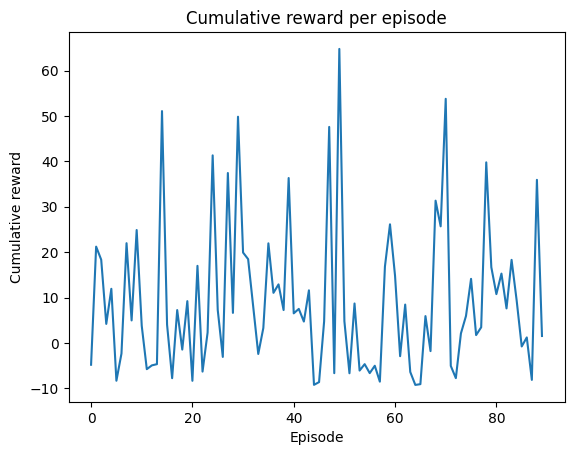

In [113]:
Q.plot_rewards_history()

In [117]:
Q.search_Q((1, 0, 1, 1, 0))

{'LANE_RIGHT': 2.4421872756646277,
 'IDLE': 0.4002800548128033,
 'LANE_LEFT': 0.37453475972036876,
 'FASTER': 0.3195998234442916,
 'SLOWER': -0.8487285128203023}

In [116]:
Q.test()

(0, 0, 0, 0, 0) FASTER (0, 0, 0, 0, 0)
(0, 0, 0, 0, 0) FASTER (0, 0, 0, 0, 0)
(0, 0, 0, 1, 0) LANE_LEFT (0, 0, 0, 1, 0)
(0, 0, 0, 1, 0) LANE_LEFT (0, 0, 0, 1, 0)
(0, 0, 0, 1, 0) LANE_LEFT (0, 0, 0, 1, 0)
(0, 0, 0, 0, 0) FASTER (0, 0, 0, 0, 0)
(0, 0, 0, 0, 0) FASTER (0, 0, 0, 0, 0)
(0, 0, 0, 0, -1) LANE_RIGHT (0, 0, 0, 0, -1)
(0, 0, 0, 0, -1) LANE_RIGHT (0, 0, 0, 0, -1)
(0, 0, 0, 0, 0) FASTER (0, 0, 0, 0, 0)
(0, 0, 0, 1, 0) LANE_LEFT (0, 0, 0, 1, 0)
(1, 0, 0, 0, 0) LANE_LEFT (1, 0, 0, 0, 0)
(0, 0, 0, 1, 0) LANE_LEFT (0, 0, 0, 1, 0)
(0, 0, 0, 1, 0) LANE_LEFT (0, 0, 0, 1, 0)
(0, 0, 0, 1, -1) IDLE (0, 0, 0, 1, -1)
(0, 0, 0, 0, -1) LANE_RIGHT (0, 0, 0, 0, -1)
(0, 0, 0, 1, -1) IDLE (0, 0, 0, 1, -1)
(0, 0, 0, 0, 0) FASTER (0, 0, 0, 0, 0)
(0, 0, 0, 0, 0) FASTER (0, 0, 0, 0, 0)
(0, 0, 0, 0, 0) FASTER (0, 0, 0, 0, 0)
(0, 0, 0, 0, 0) FASTER (0, 0, 0, 0, 0)
(0, 0, 0, 0, 0) FASTER (0, 0, 0, 0, 0)
(1, 0, 0, 0, 0) LANE_LEFT (1, 0, 0, 0, 0)
(1, 0, 0, 0, 0) LANE_LEFT (1, 0, 0, 0, 0)
(0, 0, 0, 1, -1) ID

In [49]:
sar.train(m=100, verbose=2)

  0%|          | 0/100 [00:00<?, ?it/s]

Episode 1 completed on state (1, 0, 0, 1, 0) with cumulative reward: 55.83995013308234
Q explored: 35.416666666666664
Episode 2 completed on state (0, 0, 1, 1, 0) with cumulative reward: -4.100641294579048
Q explored: 35.416666666666664
Episode 3 completed on state (0, 0, 1, 0, 0) with cumulative reward: 154.7079343001195
Q explored: 35.416666666666664


KeyboardInterrupt: 

In [42]:
sar.Q = Q_save.copy()

In [39]:
Q_save = sar.Q.copy()

In [50]:
sar.search_Q((1, 0, 0, 1, -1))

{'FASTER': 5.133641775043947,
 'LANE_RIGHT': 1.8789156890532015,
 'SLOWER': 1.7437783264494309,
 'IDLE': 0.5959434836555192,
 'LANE_LEFT': -1.1294429580928238}

In [51]:
sar.test()

(0, 0, 0, 0, 0)
(0, 0, 0, 0, 0)
(0, 0, 0, 0, 0)
(0, 0, 0, 0, 0)
(0, 0, 0, 0, 0)
(0, 0, 0, 0, 0)
(0, 0, 0, 0, 0)
(0, 0, 0, 0, 0)
(0, 0, 0, 0, 0)
(0, 0, 1, 0, 0)
(0, 0, 1, 0, 0)
(0, 0, 0, 0, 1)
(0, 0, 0, 0, 1)
(0, 0, 0, 0, 1)
(0, 0, 0, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 0, 0, 1)
(0, 0, 0, 0, 1)
(0, 0, 0, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(0, 0, 1, 0, 1)
(1, 0, 1, 0, 1)
(1, 0, 1, 0, 1)


#### Observation testing kinematics

In [63]:
obs = np.array([[111.21628   ,  28.534393  ,  24.951689  ,  -1.5534488 ],
         [  7.215894  , -28.534393  ,  -3.1784813 ,   1.5534488 ],
         [ 13.563559  ,  -9.321229  ,  -8.850195  ,   3.4367235 ],
         [ 26.42035   , -14.356143  ,  -3.1136448 ,  -3.102817  ],
         [ 32.715305  ,  -8.534393  ,  -8.347136  ,   1.5534488 ],
         [ 47.327545  ,  -4.534394  ,  -1.7440301 ,   1.5534488 ],
         [ 53.866665  ,  -8.534393  ,  -3.6438825 ,   1.5534488 ],
         [ 63.812023  , -21.71256   ,  -6.453715  ,   4.5213614 ],
         [ 74.69441   ,   6.18834   ,  -7.2160125 ,   2.12416   ],
         [ 83.25759   , -26.404202  ,  -6.699316  ,  -2.9349995 ],
         [ 91.63243   ,   6.007195  ,  -8.328622  ,  -3.1048355 ],
         [102.30845   , -14.389156  ,  -5.285321  ,  -3.018829  ],
         [113.73761   , -24.534393  ,  -3.4926977 ,   1.5534488 ],
         [120.51923   ,   7.066979  ,  -9.3168545 ,   2.4114895 ],
         [132.30734   ,   4.4144945 ,  -5.9441433 ,  -0.90478116],
         [145.12323   , -12.534393  ,  -2.4250896 ,   1.5534488 ],
         [155.93086   ,   7.465606  ,  -2.768306  ,   1.5534488 ],
         [164.46223   ,  -4.3472805 ,  -7.0121    ,   1.1194158 ],
         [178.45152   ,   3.4656062 ,  -2.5009947 ,   1.5534488 ],
         [183.40137   ,  -1.2960489 ,  -6.600557  ,   3.5758533 ],
         [195.75583   , -20.534393  ,  -3.785254  ,   1.5534488 ]])

In [69]:
lane_tolerance = 2
x_speed_coef = 1
y_speed_coef = 1
crop = 100

"""
Function to get the state of the environment
"""
def get_sign(num): 
    sign = num/np.abs(num)
    return sign

lane = obs[0,1]
observation = obs[1:][:,0:4]
observation = observation[~np.all(observation == 0, axis=1)]

# The bin 0 indicates (0, 8], which is the safety distance
# bins =  [[0,8,crop], [0,8,crop], [0,8,crop], [0,8,crop]] if bins is None else bins
# bins =  [[0,10], [0,10], [0,10], [0,10]] if bins is None else bins

# Lane observations
same_lane = observation[np.abs(observation[:,1]) <= lane_tolerance]
lane_front = same_lane[(same_lane[:,0] > 0)]
lane_back = same_lane[(same_lane[:,0] < 0)]

# For the left and right lanes we consider 2 lanes, instead of just one 
left_lanes = observation[(observation[:,1] >= -8 - lane_tolerance) & (observation[:,1] <= -4 + lane_tolerance)]
right_lanes = observation[(observation[:,1] <= 8 + lane_tolerance) & (observation[:,1] >= 4 - lane_tolerance)]

# Calculating the adjusted distances
front_dist = lane_front[0,0] if len(lane_front) > 0 else crop 
front_speed_diff = lane_front[0,2] if len(lane_front) > 0 else 0
front_adj_dist = front_dist + x_speed_coef*front_speed_diff   # The more the front speed diff, the harder it is to get to the car in the front, so adjusted distance is higher

back_dist = -lane_back[0,0] if len(lane_back) > 0 else crop
back_speed_diff = lane_back[0,2] - 5 if len(lane_back) > 0 else 0
back_adj_dist = back_dist - x_speed_coef*back_speed_diff    # The faster the car in the back is driving, the more dangerous it is, so the adjusted distance is lower

left_signs = [get_sign(left_lanes[i,0]) for i in range(len(left_lanes))]
left_adj_dists = left_lanes[:,0] + x_speed_coef*left_lanes[:,2]*left_signs - y_speed_coef*left_lanes[:,3]
left_adj_dists = np.min(left_adj_dists) if len(left_adj_dists) > 0 else crop

right_signs = [get_sign(right_lanes[i,0]) for i in range(len(right_lanes))]
right_adj_dists = right_lanes[:,0] + x_speed_coef*right_lanes[:,2]*right_signs + y_speed_coef*right_lanes[:,3]
right_adj_dists = np.min(right_adj_dists) if len(right_adj_dists) > 0 else crop

In [73]:
left_lanes

array([[ 13.563559 ,  -9.321229 ,  -8.850195 ,   3.4367235],
       [ 32.715305 ,  -8.534393 ,  -8.347136 ,   1.5534488],
       [ 47.327545 ,  -4.534394 ,  -1.7440301,   1.5534488],
       [ 53.866665 ,  -8.534393 ,  -3.6438825,   1.5534488],
       [164.46223  ,  -4.3472805,  -7.0121   ,   1.1194158]])

In [74]:
left_signs = [get_sign(left_lanes[i,0]) for i in range(len(left_lanes))]
left_adj_dists = left_lanes[:,0] + x_speed_coef*left_lanes[:,2]*left_signs - y_speed_coef*left_lanes[:,3]

In [75]:
left_adj_dists

array([  1.2766405,  22.8147202,  44.0300661,  48.6693337, 156.3307142])

In [29]:
left_lane

array([], shape=(0, 4), dtype=float32)

In [81]:
def get_state(obs, crop=100, lane_tolerance=2, danger_threshold=5, x_speed_coef=1, y_speed_coef=1, bins=None):
    """
    Function to get the state of the environment
    """
    def get_sign(num): 
        sign = num/np.abs(num)
        return sign

    lane = obs[0,1]
    observation = obs[1:][:,0:4]
    observation = observation[~np.all(observation == 0, axis=1)]

    # The bin 0 indicates (0, 8], which is the safety distance
    # bins =  [[0,8,crop], [0,8,crop], [0,8,crop], [0,8,crop]] if bins is None else bins
    # bins =  [[0,10], [0,10], [0,10], [0,10]] if bins is None else bins

    # Lane observations
    same_lane = observation[np.abs(observation[:,1]) <= lane_tolerance]
    lane_front = same_lane[(same_lane[:,0] > 0)]
    lane_back = same_lane[(same_lane[:,0] < 0)]

    # For the left and right lanes we consider 2 lanes, instead of just one 
    left_lanes = observation[(observation[:,1] >= -8 - lane_tolerance) & (observation[:,1] <= -4 + lane_tolerance)]
    right_lanes = observation[(observation[:,1] <= 8 + lane_tolerance) & (observation[:,1] >= 4 - lane_tolerance)]

    # Calculating the adjusted distances
    front_dist = lane_front[0,0] if len(lane_front) > 0 else crop 
    front_speed_diff = lane_front[0,2] if len(lane_front) > 0 else 0
    front_adj_dist = front_dist + x_speed_coef*front_speed_diff   # The more the front speed diff, the harder it is to get to the car in the front, so adjusted distance is higher

    back_dist = -lane_back[0,0] if len(lane_back) > 0 else crop
    back_speed_diff = lane_back[0,2] - 5 if len(lane_back) > 0 else 0
    back_adj_dist = back_dist - x_speed_coef*back_speed_diff    # The faster the car in the back is driving, the more dangerous it is, so the adjusted distance is lower

    left_signs = [get_sign(left_lanes[i,0]) for i in range(len(left_lanes))]
    left_adj_dists = left_lanes[:,0] + x_speed_coef*left_lanes[:,2]*left_signs - y_speed_coef*left_lanes[:,3]
    left_adj_dist = np.min(left_adj_dists) if len(left_adj_dists) > 0 else crop

    right_signs = [get_sign(right_lanes[i,0]) for i in range(len(right_lanes))]
    right_adj_dists = right_lanes[:,0] + x_speed_coef*right_lanes[:,2]*right_signs + y_speed_coef*right_lanes[:,3]
    right_adj_dist = np.min(right_adj_dists) if len(right_adj_dists) > 0 else crop

    turn_possibility = -1 if lane < 2 else 1 if lane > 34 else 0

    values = np.array([front_adj_dist, back_adj_dist, left_adj_dist, right_adj_dist])
    if bins is not None:
        values = bin_values(values, bins)
    else: 
         # Use the danger threshold to make 0 or 1 
         values = np.where(values < danger_threshold, 1, 0)
    values = np.append(values, [turn_possibility])

    return values

In [80]:
[np.mean(t) for t in danger_thresholds]

c:\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python311\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.18745937714209923, nan, -3.4536432678049263, -5.516046166419983]

In [79]:
# Lets try to find the best danger threshold 
danger_thresholds = [[],[],[],[]]

history = {}
# Run 1000 episodes
with gym.make("highway-v0", config=kinematics) as env:
    for i in tqdm(range(1000)):
        temp_hist = {}
        obs = env.reset()
        last_state = None
        for _ in range(1000):
            action = env.action_space.sample()
            obs, reward, done, truncated, info = env.step(action)
            temp_hist[_] = obs[~np.all(obs == 0, axis=1)],get_state(obs)[0:4]
            if done:
                # Check the minimum distance to the cars in obs
                loc_min = np.argmin(last_state)
                if last_state is not None:
                    danger_thresholds[loc_min].append(last_state[loc_min])
                    if last_state[loc_min] > 20:
                        print('Warning !!')
                        history = temp_hist.copy()
                    print(last_state, danger_thresholds)
                break
            last_state = get_state(obs)[0:4]

  0%|          | 0/1000 [00:00<?, ?it/s]

[ 22.95870781 100.          -3.51674032  82.20952606] [[], [], [-3.516740322113037], []]
[  0.20784283 100.          55.73577499  17.40564346] [[0.20784282684326172], [], [-3.516740322113037], []]
[ 46.52709818 100.          11.65915489  -1.81392288] [[0.20784282684326172], [], [-3.516740322113037], [-1.8139228820800781]]
[ 63.29769802 100.           8.33742332  -5.15916538] [[0.20784282684326172], [], [-3.516740322113037], [-1.8139228820800781, -5.159165382385254]]
[ 17.2305603  100.          -1.51900303  70.45836639] [[0.20784282684326172], [], [-3.516740322113037, -1.5190030336380005], [-1.8139228820800781, -5.159165382385254]]
[9.30061340e-02 1.00000000e+02 1.00000000e+02 1.96587811e+01] [[0.20784282684326172, 0.09300613403320312], [], [-3.516740322113037, -1.5190030336380005], [-1.8139228820800781, -5.159165382385254]]
[109.59207559 100.          -9.0344162    0.40899324] [[0.20784282684326172, 0.09300613403320312], [], [-3.516740322113037, -1.5190030336380005, -9.034416198730469]

KeyboardInterrupt: 

In [82]:
# Generate an episode of the environment and show the rewards and cumulative rewards
cum_reward = 0
with gym.make("highway-v0", config=kinematics, render_mode='human') as env:
    obs = env.reset()
    for _ in range(1000):
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        cum_reward += reward
        # Print non-zero obs
        obs_non = obs[~np.all(obs == 0, axis=1)]
        print(obs_non[:10])
        print(get_state(obs))
        if done:
            break
        time.sleep(2)

[[98.20936   10.211578  24.641417   4.2190776]
 [10.238828   5.788422  -1.4295353 -4.2190776]
 [20.053162  -6.211578  -2.7973175 -4.2190776]
 [31.385824  21.788422  -1.1722001 -4.2190776]
 [39.95975   25.788422  -2.625083  -4.2190776]
 [50.331      1.788422  -2.5729313 -4.2190776]
 [59.972057   9.788422  -3.5926745 -4.2190776]
 [70.92825   -2.2115781 -3.997028  -4.2190776]
 [81.38444   -2.2115781 -3.0901124 -4.2190776]
 [89.76614   -6.211578  -3.4806619 -4.2190776]]
[0 0 0 1 0]
[[111.345955   11.498738   27.945198    1.593811 ]
 [  8.702689    4.501261   -4.759802   -1.593811 ]
 [ 17.744877   -7.498739   -6.555018   -1.593811 ]
 [ 29.885103   20.50126    -5.058059   -1.593811 ]
 [ 37.808144   24.50126    -6.03821    -1.593811 ]
 [ 48.145264    0.5012613  -6.2648883  -1.593811 ]
 [ 56.967197   10.353649   -8.260862    2.9742053]
 [ 67.513855   -3.4987388 -10.300811   -1.593811 ]
 [ 78.90431    -3.4987388  -6.9523883  -1.593811 ]
 [ 86.89785    -9.747918   -7.529662   -5.6805706]]
[0 0 0

#### Time to collision

In [ ]:
class TimeToCollision:
    def __init__(horizon=5,
                policy_frequency=1,
                simulation_frequency=10):

        self.config = default_config.copy()
        self.config["observation"] =  {
        "type": "TimeToCollision",
        "horizon": horizon}
        self.config['policy_frequency'] = policy_frequency
        self.config['simulation_frequency'] = simulation_frequency

    def get_state(self, env): 
        grid = env.vehicle.speed_index
        return self.current_obs[grid]

    def test_env(self):
        with gym.make("highway-v0", config=self.config, render_mode='human') as env:
            obs = env.reset()
            for _ in range(1000):
                action = env.action_space.sample()
                obs, reward, done, truncated, info = env.step(action)
                print(self.get_state, reward)
                if done:
                    break
                time.sleep(1)

[[0.  0.  0.  0.5 1. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  0. ]]
[[0.  0.  0.  0.  0. ]
 [0.  0.  0.5 1.  1. ]
 [0.  0.  0.  0.  0. ]]
[[0.5 1.  1.  0.5 0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]
[[0.  1.  1.  0.5 0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]
[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.5 1.  1.  0.  0. ]]
[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [1.  1.  0.5 0.  0. ]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5]]
[[0.  0.  0.  0.  0.5]
 [0.  0.  0.  0.  0. ]
 [0.  0.5 1.  1.  0. ]]
[[0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  0. ]
 [0.5 1.  1.  0.  0. ]]
[[0.  0.  0.  0.  0. ]
 [1.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5]]
